In [1]:
import os
import pandas as pd

# Directory containing the .xyz files to analyze 
directory = '/home/sal/qmcf_examples/graphite_qmmm_setup/'

# Save lattice parameters in separate dataframe
latticefilename = 'graphite-md-02.xyz'
lattice = pd.read_csv(os.path.join(directory, latticefilename), delimiter='\s+', header=None, skiprows=range(2, 12500), nrows=1)

numAtoms = lattice[0][0] - 1

#guest_indices = [685, 686, 687, 688, 689, 690]#1
#guest_indices = [723, 724, 722, 721, 725, 726, 685, 686, 687, 688, 689, 690]#2
#guest_indices = [723, 724, 722, 721, 725, 726, 685, 686, 687, 688, 689, 690, 757, 758, 759, 760, 761, 762]
guest_indices = [1474, 1470, 1449, 1444, 1445, 1469, 1448, 1463, 1458, 1459, 1442, 1443, 1457, 1462, 1472, 1473, 1471, 1456] # Which atoms to track
dfs = []

# Loop through xyz files, create dataframes from them, clean them up, add indices and add them to the list of dataframes
for i, filename in enumerate(sorted(os.listdir(directory))):
    if filename.endswith('.xyz') and filename.startswith('graphite-md-02'): #change prefix
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, delimiter='\s+', header=None, skiprows=1)
        df['run'] = filename
        # drop all rows that are NaN
        df = df[~df.iloc[:, 1].isna()]
        # drop all rows that are an X element
        df = df[df[0] != 'X']
        # reset the Index of the dataframe
        df.reset_index(drop=True, inplace=True)
        # add cleanedIndex to each row representing its index in the simulation, going from 1 to numAtoms then start at 1 again
        df['cleanedIndex'] = (df.index) % (numAtoms) + 1
        #drop the entire row if the cleanedIndex is not in the guest_indices list
        df = df[df['cleanedIndex'].isin(guest_indices)]
        # append to the list of dataframes
        dfs.append(df)
        
# Concatenate all dataframes into one
df = pd.concat(dfs, ignore_index=True)


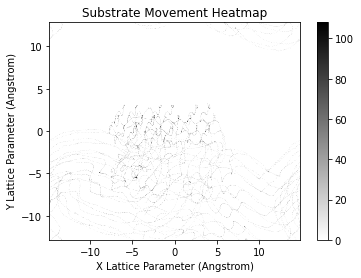

In [31]:
lattice_x = lattice[1][0]
lattice_y = lattice[2][0]

# Save second and third column of dataframe
x_values = df.iloc[:, 1]
y_values = df.iloc[:, 2]

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Adjust x-axis range and center it at zero
plt.hist2d(x_values, y_values, bins=500, cmap='binary', range=[[-lattice_x/2, lattice_x/2], [-lattice_y/2, lattice_y/2]])
plt.colorbar()
plt.xlabel('X Lattice Parameter (Angstrom)')
plt.ylabel('Y Lattice Parameter (Angstrom)')
plt.title('Substrate Movement Heatmap')

plt.gca().set_aspect('equal')  # Set aspect ratio to 'equal'+
plt.savefig("/home/sal/Desktop/Heatmap_try.png", dpi = 300)

plt.show()



0         3.5234
1         3.3594
2         3.3757
3         3.5262
4         3.2878
           ...  
224995    3.3610
224996    3.0269
224997    3.0040
224998    2.9928
224999    3.3627
Name: 3, Length: 225000, dtype: float64


FileNotFoundError: [Errno 2] No such file or directory: '/home/mfi/Desktop/mfi/images/Histogram2Guest.png'

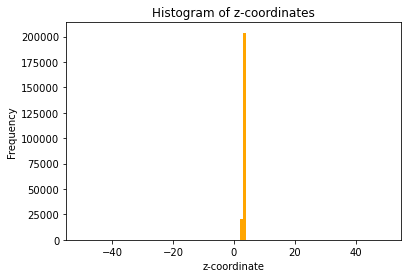

In [27]:
z_lattice = lattice[3][0]
z_values = df.iloc[:, 3]
print(z_values)

#Plot a histogram of the z values
plt.hist(z_values, bins=100, color='orange' ,range=[-z_lattice/2, z_lattice/2])
plt.xlabel('z-coordinate')
plt.ylabel('Frequency')
plt.title('Histogram of z-coordinates')
plt.savefig("/home/mfi/Desktop/mfi/images/Histogram2Guest.png")

plt.show()



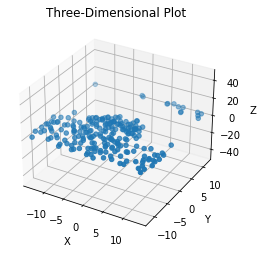

In [29]:
# Create a new figure and axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot every thousandth step
ax.scatter(x_values[::1000], y_values[::1000], z_values[::1000])

# Set ranges to lattice values
ax.set_xlim(-lattice_x/2, lattice_x/2)
ax.set_ylim(-lattice_y/2, lattice_y/2)
ax.set_zlim(-z_lattice/2, z_lattice/2)


# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Three-Dimensional Plot')

# Show the plot
plt.show()